In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.mixture import GaussianMixture
from scipy import stats
from scipy.stats import normaltest, jarque_bera
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")


In [81]:
# Load the filtered data
data = pd.read_csv('../Processed-Data/ProSeq_raw_filtered.csv')
print(f"Data shape: {data.shape}")
print(f"\nFirst few rows:")
print(data.head())

# Extract the ratio column for analysis
ratio_data = data['CPM_TUMOR/CPM_SPLEEN'].values.reshape(-1, 1)
ratio_1d = data['CPM_TUMOR/CPM_SPLEEN'].values

print(f"\nBasic statistics for CPM_TUMOR/CPM_SPLEEN ratio:")
print(f"Mean: {np.mean(ratio_1d):.4f}")
print(f"Median: {np.median(ratio_1d):.4f}")
print(f"Std: {np.std(ratio_1d):.4f}")
print(f"Skewness: {stats.skew(ratio_1d):.4f}")
print(f"Kurtosis: {stats.kurtosis(ratio_1d):.4f}")


Data shape: (8739, 7)

First few rows:
  GeneID       Ensembl_ID  CPM_TUMOR  CPM_SPLEEN  \
0   DPM1  ENSG00000000419  61.274627   47.583513   
1  SCYL3  ENSG00000000457  21.703534   31.948930   
2    FGR  ENSG00000000938   3.634080   75.151739   
3    CFH  ENSG00000000971   1.312307    8.308232   
4  FUCA2  ENSG00000001036  37.855000   31.797871   

                                              ProSeq Chr  CPM_TUMOR/CPM_SPLEEN  
0  AAGCTGCACAGTCGAGCCTGCGGCTCCGCAGCCGAATAGAGCGGAA...  20              1.287728  
1  GGGGGCAAAACTACTGCATTAATATTAAAATTTTCAAATATTACTT...   1              0.679320  
2  ATTACAGGCTGAGCCACTGCCCCCAGCCAGTTACTCAGTTTTTCTA...   1              0.048357  
3  TCCAGCATATGATTTATGTTTTCCTTATACATATTACACTACAATA...   1              0.157953  
4  TCCCAAAGTGTTGGGATTACAGGAGTGAGCCACCGCGCCCGGCCCA...   6              1.190489  

Basic statistics for CPM_TUMOR/CPM_SPLEEN ratio:
Mean: 0.9248
Median: 0.8628
Std: 0.3627
Skewness: 0.4946
Kurtosis: 0.2446


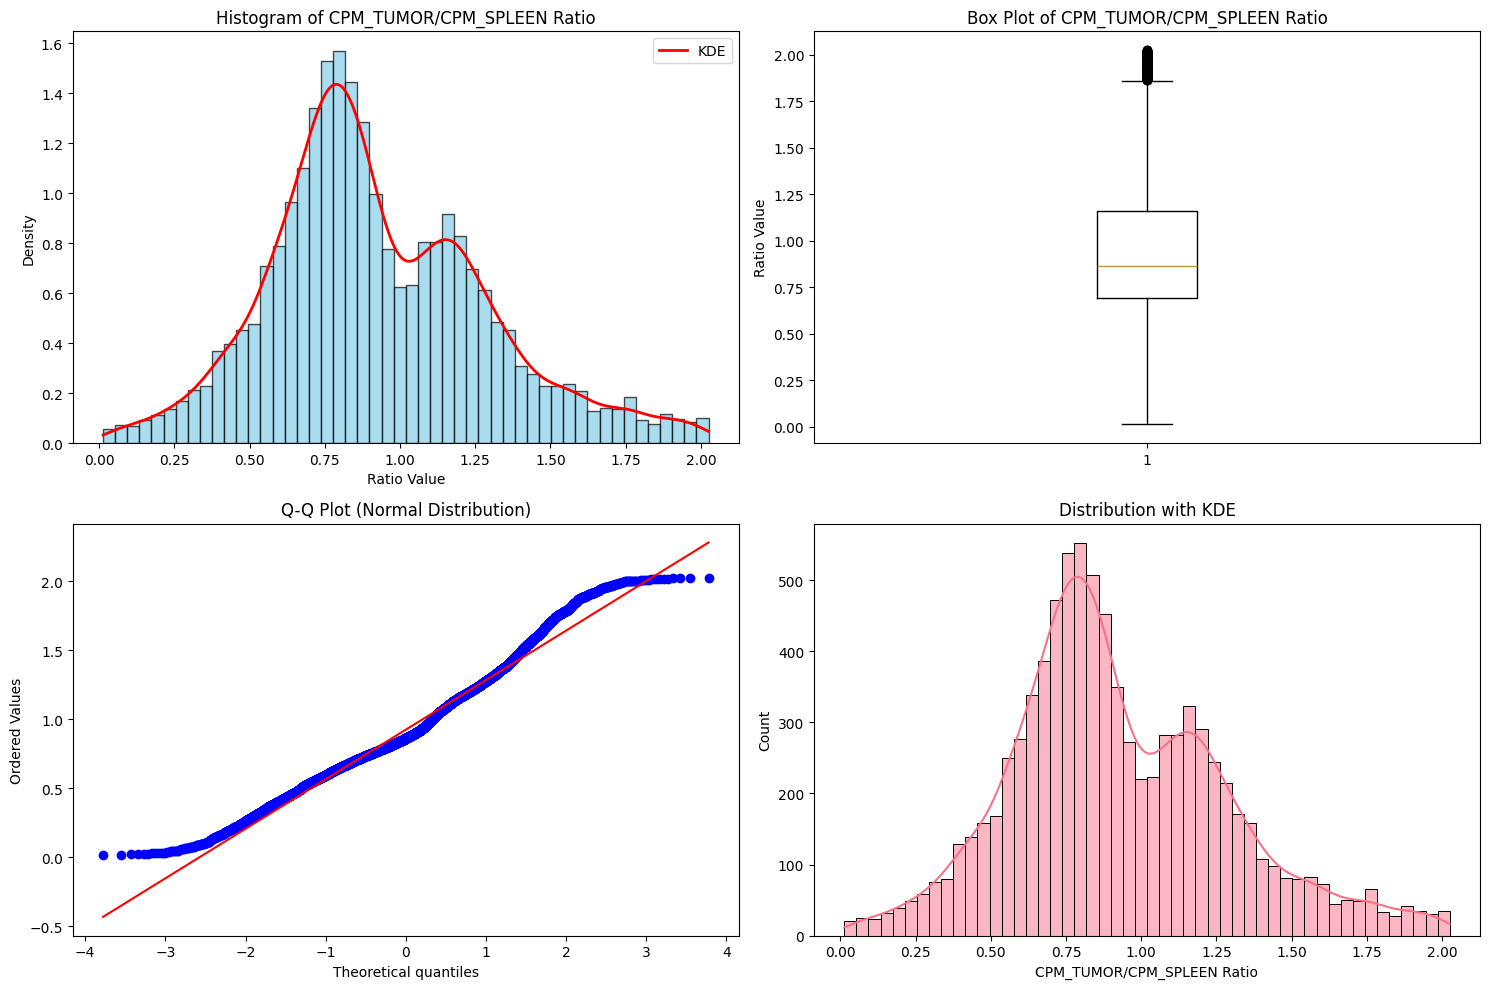

In [82]:
# Visualize the distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram with KDE
axes[0, 0].hist(ratio_1d, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Histogram of CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_xlabel('Ratio Value')
axes[0, 0].set_ylabel('Density')

# Add KDE overlay
from scipy.stats import gaussian_kde
kde = gaussian_kde(ratio_1d)
x_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000)
axes[0, 0].plot(x_range, kde(x_range), 'r-', linewidth=2, label='KDE')
axes[0, 0].legend()

# Box plot
axes[0, 1].boxplot(ratio_1d)
axes[0, 1].set_title('Box Plot of CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Ratio Value')

# Q-Q plot
stats.probplot(ratio_1d, dist="norm", plot=axes[1, 0])
axes[1, 0].set_title('Q-Q Plot (Normal Distribution)')

# Seaborn distribution plot
sns.histplot(ratio_1d, kde=True, ax=axes[1, 1], bins=50)
axes[1, 1].set_title('Distribution with KDE')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')

plt.tight_layout()
plt.show()


In [83]:
# Fit GMM models with different numbers of components
n_components_range = range(1, 10)
models = {}
aic_scores = []
bic_scores = []
log_likelihoods = []

print("Fitting GMM models with different numbers of components...")
print("\nComponent\tAIC\t\tBIC\t\tLog-Likelihood")
print("-" * 60)

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42)
    gmm.fit(ratio_data)
    
    models[n_components] = gmm
    aic = gmm.aic(ratio_data)
    bic = gmm.bic(ratio_data)
    log_likelihood = gmm.score(ratio_data) * len(ratio_data)
    
    aic_scores.append(aic)
    bic_scores.append(bic)
    log_likelihoods.append(log_likelihood)
    
    print(f"{n_components}\t\t{aic:.2f}\t\t{bic:.2f}\t\t{log_likelihood:.2f}")

# Find optimal number of components
optimal_aic = n_components_range[np.argmin(aic_scores)]
optimal_bic = n_components_range[np.argmin(bic_scores)]

print(f"\nOptimal number of components:")
print(f"Based on AIC: {optimal_aic}")
print(f"Based on BIC: {optimal_bic}")


Fitting GMM models with different numbers of components...

Component	AIC		BIC		Log-Likelihood
------------------------------------------------------------
1		7077.43		7091.59		-3536.72
2		6647.83		6683.21		-3318.92
3		6677.74		6734.34		-3330.87
4		6266.31		6344.14		-3122.15
5		6280.74		6379.80		-3126.37
6		6257.33		6377.62		-3111.67
7		6264.76		6406.27		-3112.38
8		6248.58		6411.32		-3101.29
9		6256.67		6440.63		-3102.33

Optimal number of components:
Based on AIC: 8
Based on BIC: 4


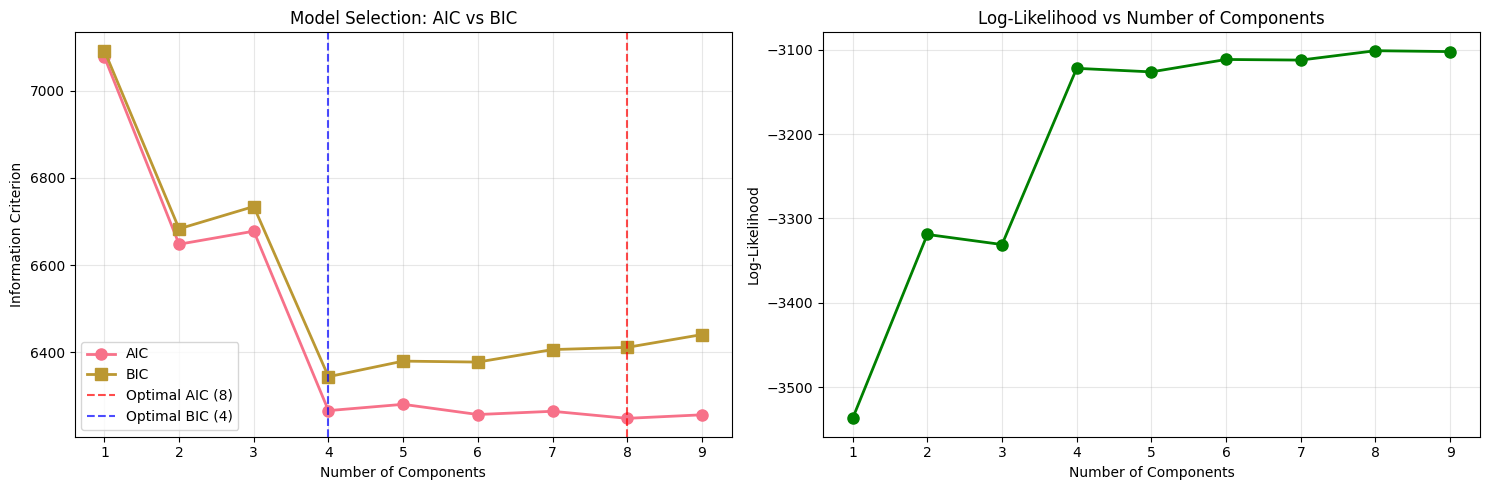

In [84]:
# Plot model selection criteria
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# AIC and BIC comparison
ax1.plot(n_components_range, aic_scores, 'o-', label='AIC', linewidth=2, markersize=8)
ax1.plot(n_components_range, bic_scores, 's-', label='BIC', linewidth=2, markersize=8)
ax1.axvline(x=optimal_aic, color='red', linestyle='--', alpha=0.7, label=f'Optimal AIC ({optimal_aic})')
ax1.axvline(x=optimal_bic, color='blue', linestyle='--', alpha=0.7, label=f'Optimal BIC ({optimal_bic})')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Information Criterion')
ax1.set_title('Model Selection: AIC vs BIC')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Log-likelihood
ax2.plot(n_components_range, log_likelihoods, 'o-', color='green', linewidth=2, markersize=8)
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('Log-Likelihood')
ax2.set_title('Log-Likelihood vs Number of Components')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [85]:
# Likelihood Ratio Test for bimodality
from scipy.stats import chi2

# Calculate likelihood ratio test statistic
gmm_1 = models[1]
gmm_2 = models[2]

ll_1 = gmm_1.score(ratio_data) * len(ratio_data)
ll_2 = gmm_2.score(ratio_data) * len(ratio_data)
lr_statistic = 2 * (ll_2 - ll_1)

# Degrees of freedom difference (2-component has 3 more parameters than 1-component)
df = 3
p_value = 1 - chi2.cdf(lr_statistic, df)

print("=== Likelihood Ratio Test ===")
print(f"H0: Data is unimodal (1 component)")
print(f"H1: Data is bimodal (2 components)")
print(f"\nLog-likelihood (1-component): {ll_1:.2f}")
print(f"Log-likelihood (2-component): {ll_2:.2f}")
print(f"LR statistic: {lr_statistic:.2f}")
print(f"Degrees of freedom: {df}")
print(f"P-value: {p_value:.2e}")

alpha = 0.05
if p_value < alpha:
    print(f"\n✓ REJECT H0 at α = {alpha}")
    print("✓ Evidence for BIMODALITY")
else:
    print(f"\n✗ FAIL TO REJECT H0 at α = {alpha}")
    print("✗ No strong evidence for bimodality")


=== Likelihood Ratio Test ===
H0: Data is unimodal (1 component)
H1: Data is bimodal (2 components)

Log-likelihood (1-component): -3536.72
Log-likelihood (2-component): -3318.92
LR statistic: 435.60
Degrees of freedom: 3
P-value: 0.00e+00

✓ REJECT H0 at α = 0.05
✓ Evidence for BIMODALITY


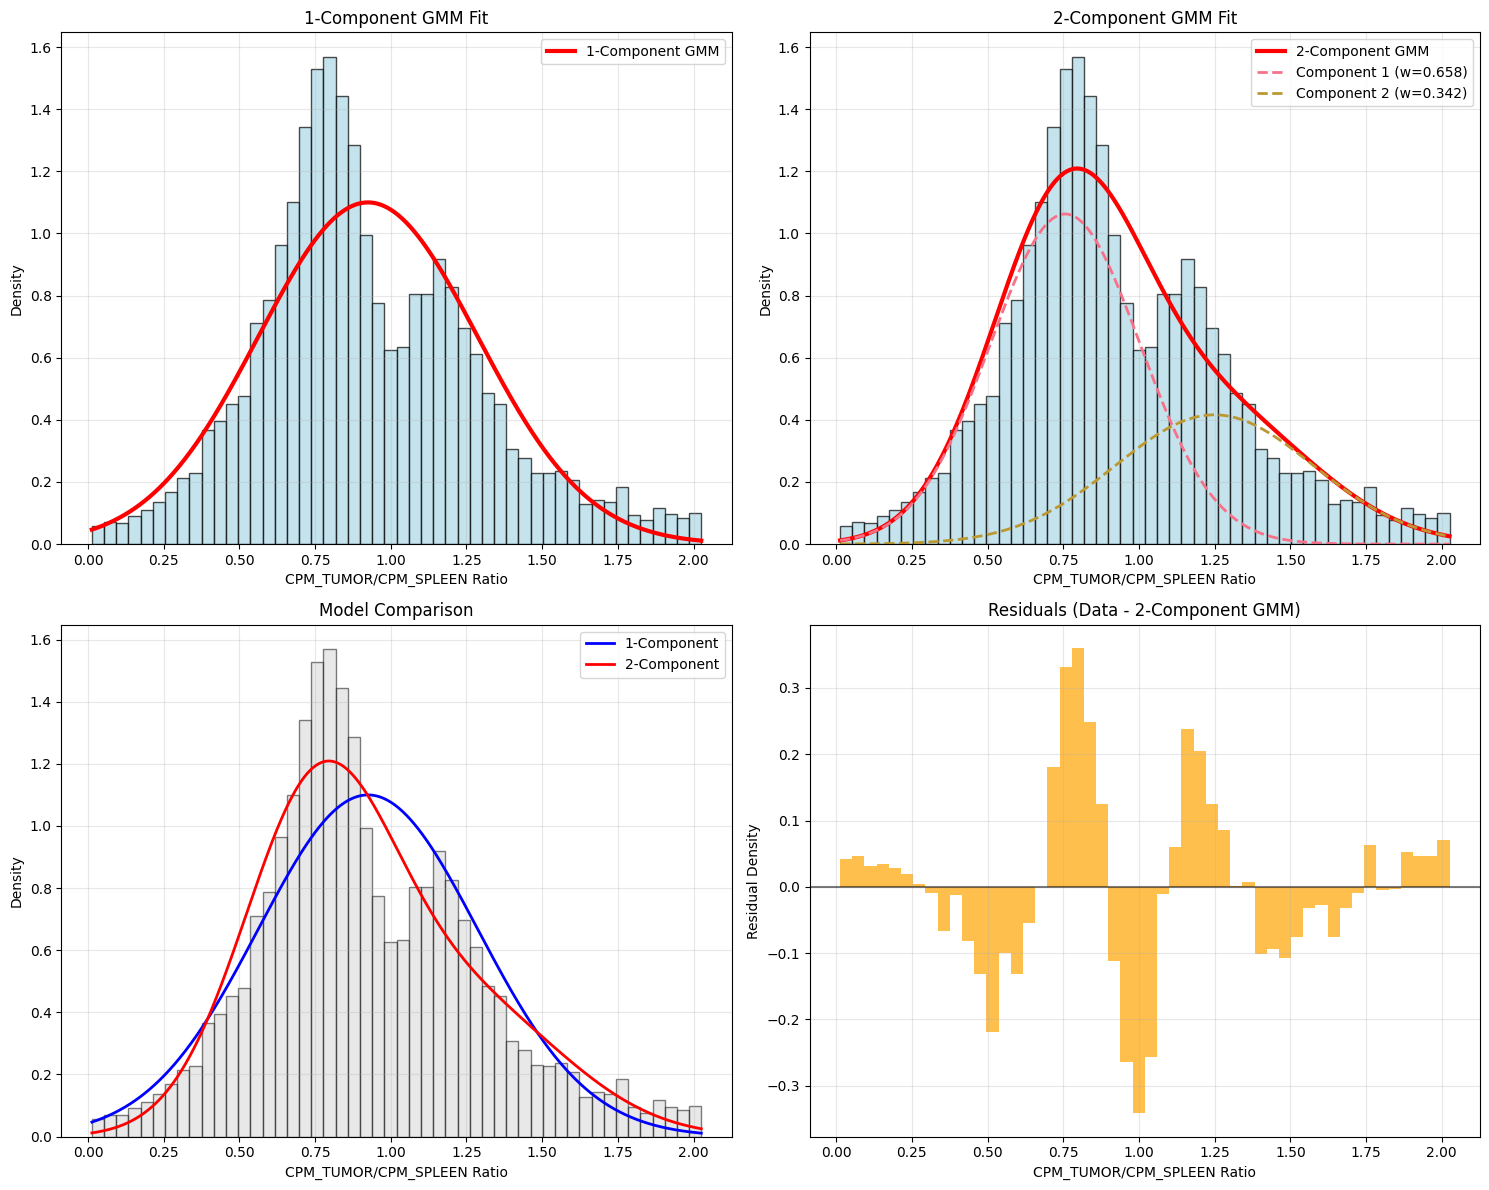

In [86]:
# Visualize GMM fits
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

x_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000).reshape(-1, 1)
x_range_1d = x_range.flatten()

# 1-Component Model
axes[0, 0].hist(ratio_1d, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
gmm1_pdf = np.exp(gmm_1.score_samples(x_range))
axes[0, 0].plot(x_range_1d, gmm1_pdf, 'r-', linewidth=3, label='1-Component GMM')
axes[0, 0].set_title('1-Component GMM Fit')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2-Component Model
axes[0, 1].hist(ratio_1d, bins=50, density=True, alpha=0.7, color='lightblue', edgecolor='black')
gmm2_pdf = np.exp(gmm_2.score_samples(x_range))
axes[0, 1].plot(x_range_1d, gmm2_pdf, 'r-', linewidth=3, label='2-Component GMM')

# Plot individual components
responsibilities = gmm_2.predict_proba(x_range)
for i in range(2):
    component_pdf = responsibilities[:, i] * gmm2_pdf
    axes[0, 1].plot(x_range_1d, component_pdf, '--', linewidth=2, 
                   label=f'Component {i+1} (w={gmm_2.weights_[i]:.3f})')

axes[0, 1].set_title('2-Component GMM Fit')
axes[0, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Comparison of both models
axes[1, 0].hist(ratio_1d, bins=50, density=True, alpha=0.5, color='lightgray', edgecolor='black')
axes[1, 0].plot(x_range_1d, gmm1_pdf, 'b-', linewidth=2, label='1-Component')
axes[1, 0].plot(x_range_1d, gmm2_pdf, 'r-', linewidth=2, label='2-Component')
axes[1, 0].set_title('Model Comparison')
axes[1, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Residuals (Data - 2-component fit)
hist_counts, bin_edges = np.histogram(ratio_1d, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
gmm2_at_bins = np.exp(gmm_2.score_samples(bin_centers.reshape(-1, 1)))
residuals = hist_counts - gmm2_at_bins

axes[1, 1].bar(bin_centers, residuals, width=np.diff(bin_edges)[0], alpha=0.7, color='orange')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 1].set_title('Residuals (Data - 2-Component GMM)')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Residual Density')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [87]:
# Summary of findings
print("=" * 60)
print("BIMODALITY ANALYSIS SUMMARY")
print("=" * 60)

print(f"\nData characteristics:")
print(f"  • Sample size: {len(ratio_1d):,}")
print(f"  • Mean ratio: {np.mean(ratio_1d):.4f}")
print(f"  • Standard deviation: {np.std(ratio_1d):.4f}")
print(f"  • Skewness: {stats.skew(ratio_1d):.4f}")
print(f"  • Kurtosis: {stats.kurtosis(ratio_1d):.4f}")

# Calculate improvement metrics
aic_improvement = gmm_1.aic(ratio_data) - gmm_2.aic(ratio_data)
bic_improvement = gmm_1.bic(ratio_data) - gmm_2.bic(ratio_data)

print(f"\nModel selection results:")
print(f"  • Optimal components (AIC): {optimal_aic}")
print(f"  • Optimal components (BIC): {optimal_bic}")
print(f"  • AIC improvement (2 vs 1): {aic_improvement:.2f}")
print(f"  • BIC improvement (2 vs 1): {bic_improvement:.2f}")

print(f"\nLikelihood ratio test:")
print(f"  • LR statistic: {lr_statistic:.2f}")
print(f"  • P-value: {p_value:.2e}")
print(f"  • Result: {'BIMODAL' if p_value < 0.05 else 'UNIMODAL'} (α = 0.05)")

# Final conclusion
evidence_count = 0
if aic_improvement > 0: evidence_count += 1
if bic_improvement > 0: evidence_count += 1  
if p_value < 0.05: evidence_count += 1

print(f"\nCONCLUSION:")
if evidence_count >= 2:
    print(f"  ✓ STRONG EVIDENCE FOR BIMODALITY")
    print(f"  ✓ The CPM_TUMOR/CPM_SPLEEN ratio data shows bimodal distribution")
elif evidence_count == 1:
    print(f"  ⚠ WEAK EVIDENCE FOR BIMODALITY")
    print(f"  ⚠ Some support for bimodality, but not conclusive")
else:
    print(f"  ✗ NO STRONG EVIDENCE FOR BIMODALITY")
    print(f"  ✗ Data appears to be unimodal")

print("\n" + "=" * 60)


BIMODALITY ANALYSIS SUMMARY

Data characteristics:
  • Sample size: 8,739
  • Mean ratio: 0.9248
  • Standard deviation: 0.3627
  • Skewness: 0.4946
  • Kurtosis: 0.2446

Model selection results:
  • Optimal components (AIC): 8
  • Optimal components (BIC): 4
  • AIC improvement (2 vs 1): 429.60
  • BIC improvement (2 vs 1): 408.38

Likelihood ratio test:
  • LR statistic: 435.60
  • P-value: 0.00e+00
  • Result: BIMODAL (α = 0.05)

CONCLUSION:
  ✓ STRONG EVIDENCE FOR BIMODALITY
  ✓ The CPM_TUMOR/CPM_SPLEEN ratio data shows bimodal distribution



In [88]:
# Function to get component probabilities for any ratio value
def get_component_probabilities(ratio_value, gmm_model):
    """
    Get the probability of a ratio value belonging to each component
    
    Parameters:
    ratio_value: float or array-like, the CPM_TUMOR/CPM_SPLEEN ratio value(s)
    gmm_model: fitted GaussianMixture model
    
    Returns:
    probabilities: array of probabilities for each component
    """
    # Ensure input is in the right shape
    if isinstance(ratio_value, (int, float)):
        ratio_value = np.array([[ratio_value]])
    else:
        ratio_value = np.array(ratio_value).reshape(-1, 1)
    
    # Get probabilities
    probabilities = gmm_model.predict_proba(ratio_value)
    
    return probabilities

# Example usage with the 2-component model
print("=== Component Probability Calculator ===")
print("Using the 2-component GMM model\n")

# Show component characteristics
print("Component characteristics:")
for i in range(2):
    print(f"Component {i+1}:")
    print(f"  Weight: {gmm_2.weights_[i]:.4f}")
    print(f"  Mean: {gmm_2.means_[i][0]:.4f}")
    print(f"  Std: {np.sqrt(gmm_2.covariances_[i][0][0]):.4f}")

print("\n" + "-"*50)


=== Component Probability Calculator ===
Using the 2-component GMM model

Component characteristics:
Component 1:
  Weight: 0.6581
  Mean: 0.7564
  Std: 0.2471
Component 2:
  Weight: 0.3419
  Mean: 1.2491
  Std: 0.3278

--------------------------------------------------


In [89]:
# Examples with specific ratio values
print("Examples with specific ratio values:\n")

# Test with some example values
test_ratios = [0.5, 0.8, 1.0, 1.2, 1.5]

for ratio in test_ratios:
    probs = get_component_probabilities(ratio, gmm_2)
    print(f"Ratio = {ratio:.1f}:")
    print(f"  P(Component 1) = {probs[0][0]:.4f}")
    print(f"  P(Component 2) = {probs[0][1]:.4f}")
    
    # Determine most likely component
    most_likely = np.argmax(probs[0]) + 1
    confidence = np.max(probs[0])
    print(f"  → Most likely: Component {most_likely} (confidence: {confidence:.4f})")
    print()

print("-"*50)


Examples with specific ratio values:

Ratio = 0.5:
  P(Component 1) = 0.9531
  P(Component 2) = 0.0469
  → Most likely: Component 1 (confidence: 0.9531)

Ratio = 0.8:
  P(Component 1) = 0.8654
  P(Component 2) = 0.1346
  → Most likely: Component 1 (confidence: 0.8654)

Ratio = 1.0:
  P(Component 1) = 0.6770
  P(Component 2) = 0.3230
  → Most likely: Component 1 (confidence: 0.6770)

Ratio = 1.2:
  P(Component 1) = 0.3399
  P(Component 2) = 0.6601
  → Most likely: Component 2 (confidence: 0.6601)

Ratio = 1.5:
  P(Component 1) = 0.0356
  P(Component 2) = 0.9644
  → Most likely: Component 2 (confidence: 0.9644)

--------------------------------------------------


In [90]:
# Examples from actual data
print("Examples from actual data:\n")

# Get some random samples from the data
np.random.seed(42)
sample_indices = np.random.choice(len(ratio_1d), 10, replace=False)
sample_ratios = ratio_1d[sample_indices]

print("Sample data points:")
for i, ratio in enumerate(sample_ratios):
    probs = get_component_probabilities(ratio, gmm_2)
    print(f"Data point {i+1}: Ratio = {ratio:.4f}")
    print(f"  P(Component 1) = {probs[0][0]:.4f}")
    print(f"  P(Component 2) = {probs[0][1]:.4f}")
    
    # Determine most likely component
    most_likely = np.argmax(probs[0]) + 1
    confidence = np.max(probs[0])
    print(f"  → Component {most_likely} (confidence: {confidence:.4f})")
    print()

print("-"*50)


Examples from actual data:

Sample data points:
Data point 1: Ratio = 1.3748
  P(Component 1) = 0.1070
  P(Component 2) = 0.8930
  → Component 2 (confidence: 0.8930)

Data point 2: Ratio = 1.2567
  P(Component 1) = 0.2474
  P(Component 2) = 0.7526
  → Component 2 (confidence: 0.7526)

Data point 3: Ratio = 1.1951
  P(Component 1) = 0.3485
  P(Component 2) = 0.6515
  → Component 2 (confidence: 0.6515)

Data point 4: Ratio = 1.9458
  P(Component 1) = 0.0002
  P(Component 2) = 0.9998
  → Component 2 (confidence: 0.9998)

Data point 5: Ratio = 0.6315
  P(Component 1) = 0.9299
  P(Component 2) = 0.0701
  → Component 1 (confidence: 0.9299)

Data point 6: Ratio = 1.1726
  P(Component 1) = 0.3883
  P(Component 2) = 0.6117
  → Component 2 (confidence: 0.6117)

Data point 7: Ratio = 1.2361
  P(Component 1) = 0.2794
  P(Component 2) = 0.7206
  → Component 2 (confidence: 0.7206)

Data point 8: Ratio = 0.7067
  P(Component 1) = 0.9078
  P(Component 2) = 0.0922
  → Component 1 (confidence: 0.9078)



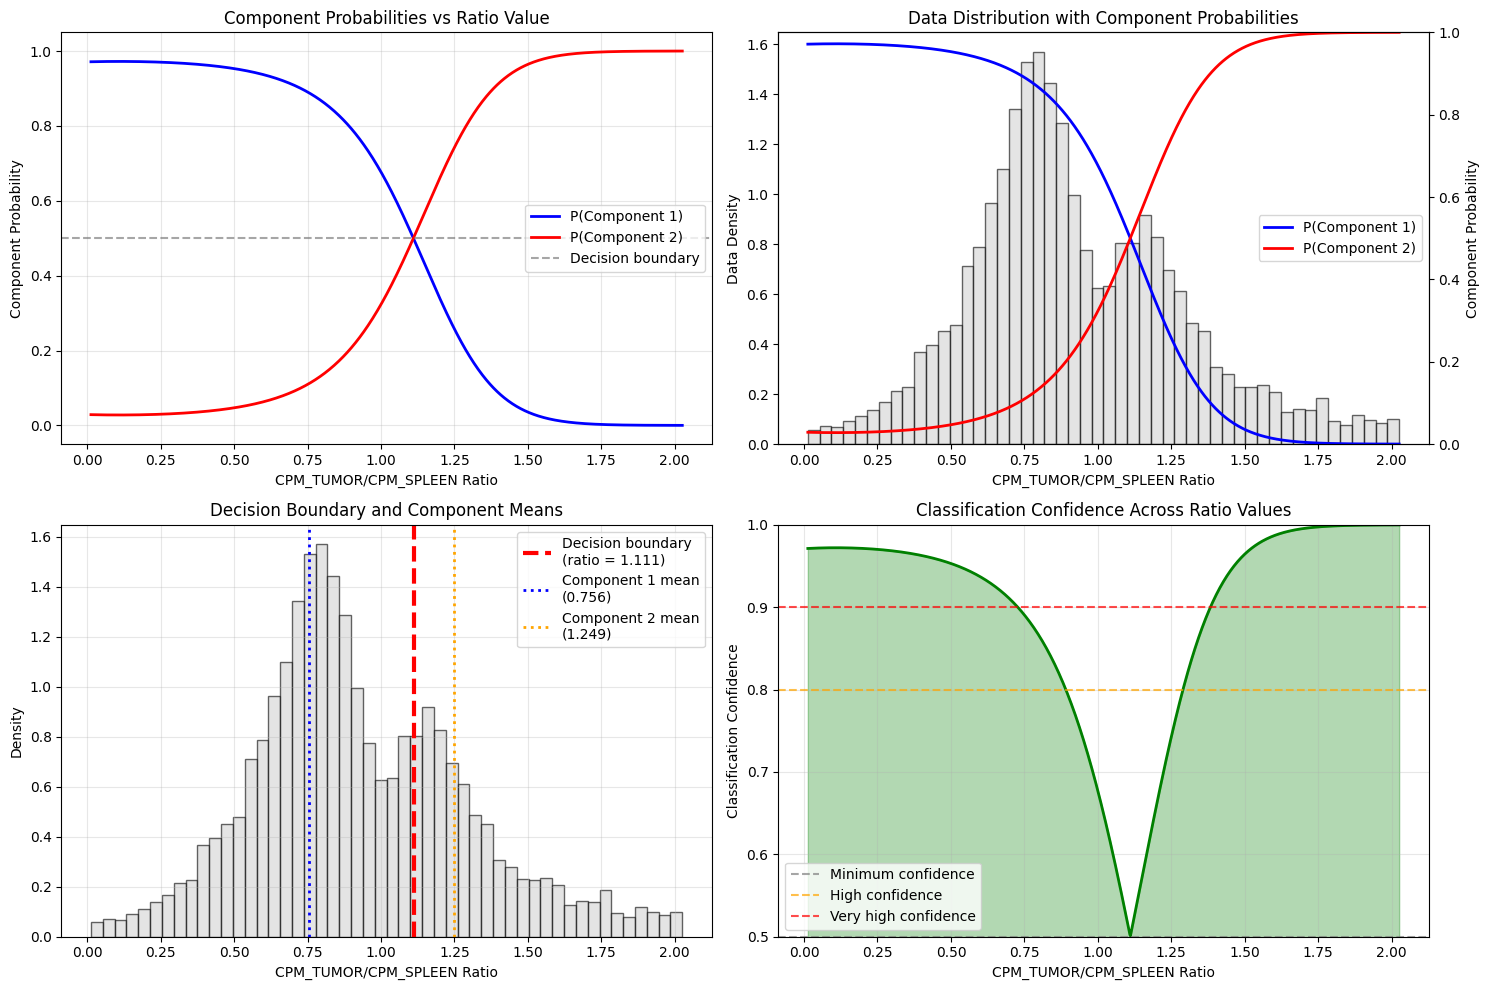

In [91]:
# Visualize component probabilities across the full range
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Create a range of ratio values for visualization
ratio_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000)
probs_range = get_component_probabilities(ratio_range, gmm_2)

# Plot 1: Component probabilities vs ratio value
axes[0, 0].plot(ratio_range, probs_range[:, 0], 'b-', linewidth=2, label='P(Component 1)')
axes[0, 0].plot(ratio_range, probs_range[:, 1], 'r-', linewidth=2, label='P(Component 2)')
axes[0, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Decision boundary')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Component Probability')
axes[0, 0].set_title('Component Probabilities vs Ratio Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Histogram with probability overlay
axes[0, 1].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')
ax_twin = axes[0, 1].twinx()
ax_twin.plot(ratio_range, probs_range[:, 0], 'b-', linewidth=2, label='P(Component 1)')
ax_twin.plot(ratio_range, probs_range[:, 1], 'r-', linewidth=2, label='P(Component 2)')
ax_twin.set_ylabel('Component Probability')
ax_twin.set_ylim(0, 1)
axes[0, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Data Density')
axes[0, 1].set_title('Data Distribution with Component Probabilities')
ax_twin.legend()

# Plot 3: Decision boundary visualization
decision_boundary = ratio_range[np.abs(probs_range[:, 0] - 0.5).argmin()]
axes[1, 0].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')
axes[1, 0].axvline(x=decision_boundary, color='red', linestyle='--', linewidth=3, 
                  label=f'Decision boundary\n(ratio = {decision_boundary:.3f})')
axes[1, 0].axvline(x=gmm_2.means_[0][0], color='blue', linestyle=':', linewidth=2, 
                  label=f'Component 1 mean\n({gmm_2.means_[0][0]:.3f})')
axes[1, 0].axvline(x=gmm_2.means_[1][0], color='orange', linestyle=':', linewidth=2, 
                  label=f'Component 2 mean\n({gmm_2.means_[1][0]:.3f})')
axes[1, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 0].set_ylabel('Density')
axes[1, 0].set_title('Decision Boundary and Component Means')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Confidence levels
confidence_levels = np.max(probs_range, axis=1)
axes[1, 1].plot(ratio_range, confidence_levels, 'g-', linewidth=2)
axes[1, 1].fill_between(ratio_range, confidence_levels, alpha=0.3, color='green')
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Minimum confidence')
axes[1, 1].axhline(y=0.8, color='orange', linestyle='--', alpha=0.7, label='High confidence')
axes[1, 1].axhline(y=0.9, color='red', linestyle='--', alpha=0.7, label='Very high confidence')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Classification Confidence')
axes[1, 1].set_title('Classification Confidence Across Ratio Values')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim(0.5, 1.0)

plt.tight_layout()
plt.show()


In [92]:
# Practical utility: Classify new ratio values
def classify_ratio(ratio_value, confidence_threshold=0.7):
    """
    Classify a CPM_TUMOR/CPM_SPLEEN ratio and provide interpretation
    
    Parameters:
    ratio_value: float, the ratio to classify
    confidence_threshold: float, minimum confidence for reliable classification
    
    Returns:
    dict with classification results
    """
    probs = get_component_probabilities(ratio_value, gmm_2)
    component_1_prob = probs[0][0]
    component_2_prob = probs[0][1]
    
    # Determine most likely component
    if component_1_prob > component_2_prob:
        predicted_component = 1
        confidence = component_1_prob
    else:
        predicted_component = 2
        confidence = component_2_prob
    
    # Determine reliability
    if confidence >= confidence_threshold:
        reliability = "High"
    elif confidence >= 0.6:
        reliability = "Medium"
    else:
        reliability = "Low"
    
    return {
        'ratio': ratio_value,
        'predicted_component': predicted_component,
        'confidence': confidence,
        'reliability': reliability,
        'component_1_prob': component_1_prob,
        'component_2_prob': component_2_prob,
        'interpretation': f"Ratio {ratio_value:.4f} → Component {predicted_component} ({confidence:.1%} confidence, {reliability.lower()} reliability)"
    }

print("=== Practical Classification Tool ===")
print("Use classify_ratio() to classify any new CPM_TUMOR/CPM_SPLEEN ratio\n")

# Examples
test_values = [0.6, 0.9, 1.1, 1.4]
print("Examples:")
for value in test_values:
    result = classify_ratio(value)
    print(f"• {result['interpretation']}")

print(f"\nComponent characteristics reminder:")
print(f"• Component 1: Lower ratios (mean ≈ {gmm_2.means_[0][0]:.3f})")
print(f"• Component 2: Higher ratios (mean ≈ {gmm_2.means_[1][0]:.3f})")
print(f"• Decision boundary: ≈ {decision_boundary:.3f}")


=== Practical Classification Tool ===
Use classify_ratio() to classify any new CPM_TUMOR/CPM_SPLEEN ratio

Examples:
• Ratio 0.6000 → Component 1 (93.7% confidence, high reliability)
• Ratio 0.9000 → Component 1 (79.2% confidence, high reliability)
• Ratio 1.1000 → Component 1 (51.8% confidence, low reliability)
• Ratio 1.4000 → Component 2 (91.3% confidence, high reliability)

Component characteristics reminder:
• Component 1: Lower ratios (mean ≈ 0.756)
• Component 2: Higher ratios (mean ≈ 1.249)
• Decision boundary: ≈ 1.111


In [ ]:
# Save component probabilities for all data points
print("=== Saving Component Probabilities for All Data ===")

# Get probabilities for all data points
all_probabilities = get_component_probabilities(ratio_1d, gmm_2)

# Add probabilities to the original dataframe
data_with_probs = data.copy()
data_with_probs['Component_1_Probability'] = all_probabilities[:, 0]
data_with_probs['Component_2_Probability'] = all_probabilities[:, 1]

# Add predicted component (most likely)
data_with_probs['Predicted_Component'] = np.argmax(all_probabilities, axis=1) + 1

# Add confidence (highest probability)
data_with_probs['Classification_Confidence'] = np.max(all_probabilities, axis=1)

# Add reliability assessment
def assess_reliability(confidence):
    if confidence >= 0.7:
        return "High"
    elif confidence >= 0.6:
        return "Medium"
    else:
        return "Low"

data_with_probs['Reliability'] = data_with_probs['Classification_Confidence'].apply(assess_reliability)

# Save to CSV
output_file = '../Processed-Data/ProSeq_with_component_probabilities.csv'
data_with_probs.to_csv(output_file, index=False)





=== Saving Component Probabilities for All Data ===
Component assignment summary:
Predicted_Component
1    6193
2    2546
Name: count, dtype: int64

Reliability distribution:
Reliability
High      7110
Medium     824
Low        805
Name: count, dtype: int64

Confidence statistics:
Mean confidence: 0.8334
Min confidence: 0.5002
Max confidence: 0.9999

✓ Saved complete dataset with component probabilities to: ../Processed-Data/ProSeq_with_component_probabilities.csv

First 5 rows with probabilities:
   CPM_TUMOR/CPM_SPLEEN  Component_1_Probability  Component_2_Probability  \
0              1.287728                 0.202836                 0.797164   
1              0.679320                 0.916822                 0.083178   
2              0.048357                 0.971842                 0.028158   
3              0.157953                 0.971949                 0.028051   
4              1.190489                 0.356527                 0.643473   

   Predicted_Component  Classifica

In [94]:
# Analysis of 4-Component Model (Optimal AIC)
print("=" * 60)
print("4-COMPONENT MODEL ANALYSIS (OPTIMAL AIC)")
print("=" * 60)

gmm_4 = models[4]

print("=== 4-Component Model Details ===")
for i in range(4):
    print(f"Component {i+1}:")
    print(f"  Weight: {gmm_4.weights_[i]:.4f} ({gmm_4.weights_[i]*100:.1f}%)")
    print(f"  Mean: {gmm_4.means_[i][0]:.4f}")
    print(f"  Std: {np.sqrt(gmm_4.covariances_[i][0][0]):.4f}")

print(f"\nModel Performance:")
print(f"AIC: {gmm_4.aic(ratio_data):.2f}")
print(f"BIC: {gmm_4.bic(ratio_data):.2f}")
print(f"Log-likelihood: {gmm_4.score(ratio_data) * len(ratio_data):.2f}")

# Compare with 2-component model
aic_improvement_4vs2 = gmm_2.aic(ratio_data) - gmm_4.aic(ratio_data)
bic_improvement_4vs2 = gmm_2.bic(ratio_data) - gmm_4.bic(ratio_data)

print(f"\nComparison with 2-component model:")
print(f"AIC improvement (4 vs 2): {aic_improvement_4vs2:.2f}")
print(f"BIC improvement (4 vs 2): {bic_improvement_4vs2:.2f}")

if aic_improvement_4vs2 > 0:
    print("✓ 4-component model is better according to AIC")
else:
    print("✗ 2-component model is better according to AIC")
    
if bic_improvement_4vs2 > 0:
    print("✓ 4-component model is better according to BIC")
else:
    print("✗ 2-component model is better according to BIC")


4-COMPONENT MODEL ANALYSIS (OPTIMAL AIC)
=== 4-Component Model Details ===
Component 1:
  Weight: 0.4332 (43.3%)
  Mean: 0.7913
  Std: 0.1180
Component 2:
  Weight: 0.0964 (9.6%)
  Mean: 1.6344
  Std: 0.2009
Component 3:
  Weight: 0.1892 (18.9%)
  Mean: 0.4918
  Std: 0.1872
Component 4:
  Weight: 0.2812 (28.1%)
  Mean: 1.1788
  Std: 0.1348

Model Performance:
AIC: 6266.31
BIC: 6344.14
Log-likelihood: -3122.15

Comparison with 2-component model:
AIC improvement (4 vs 2): 381.52
BIC improvement (4 vs 2): 339.07
✓ 4-component model is better according to AIC
✓ 4-component model is better according to BIC


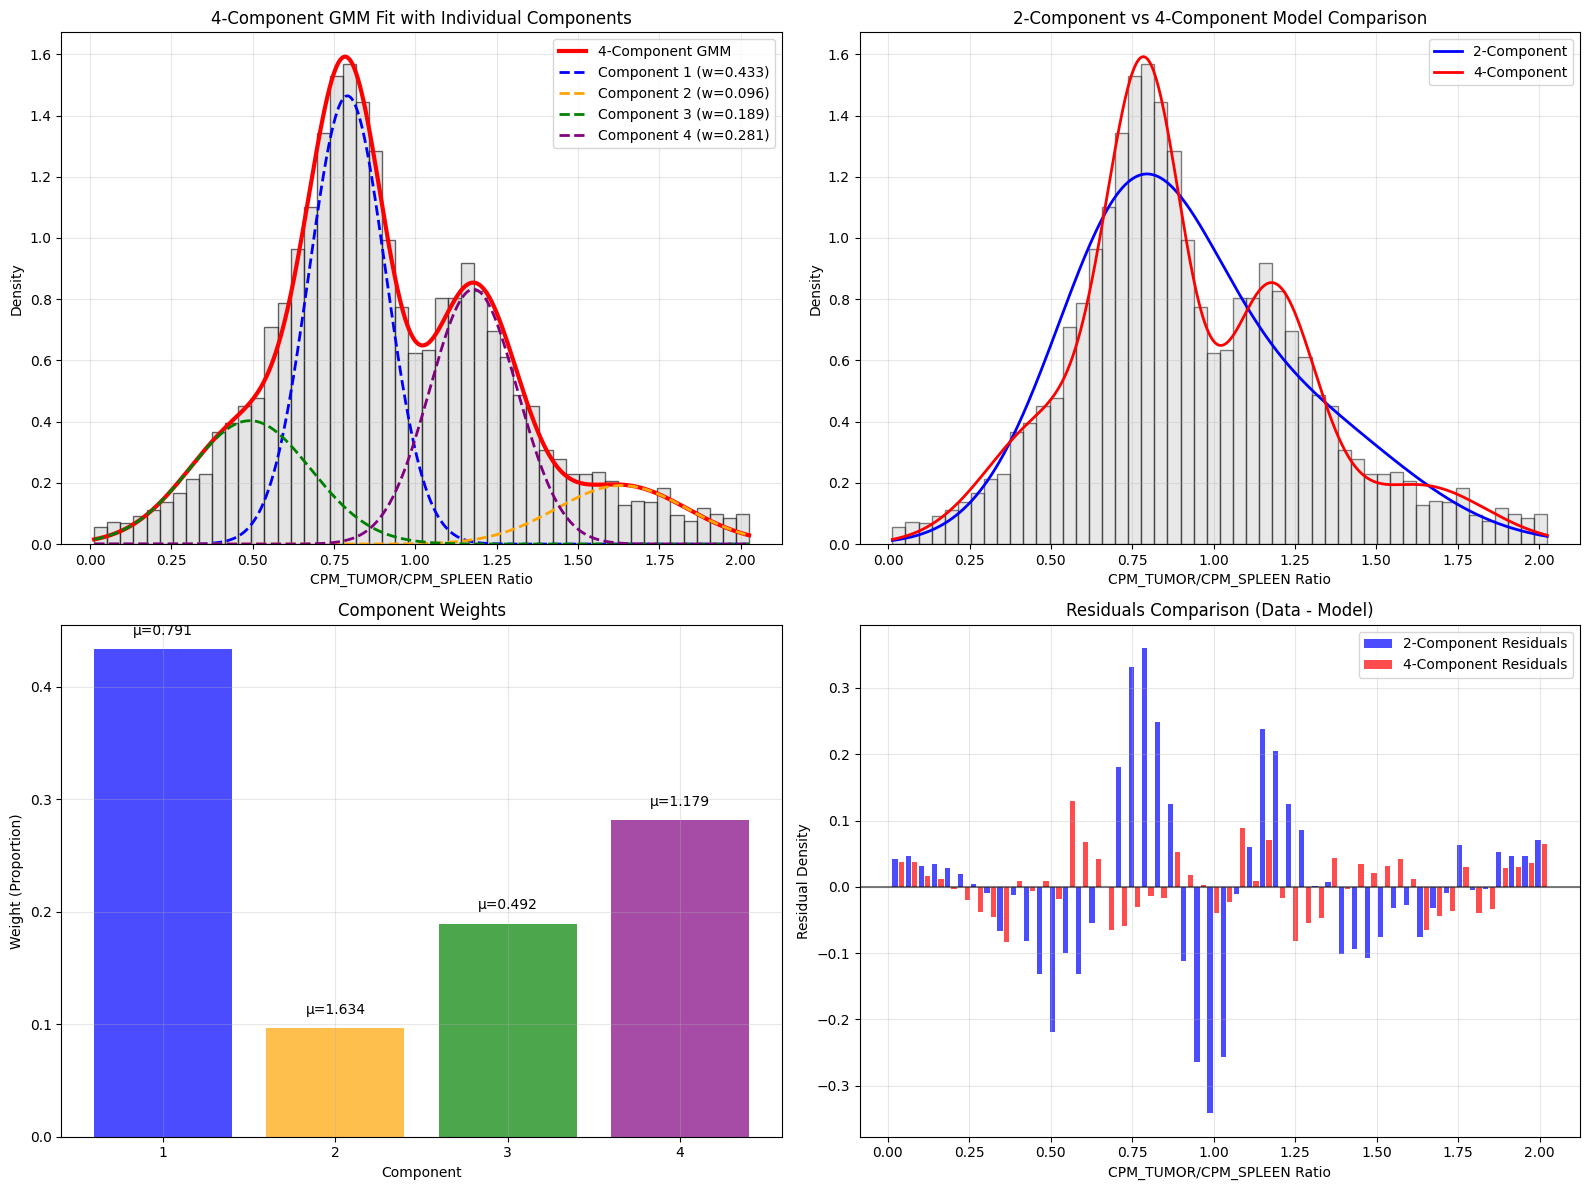


Residual Analysis:
RMSE (2-component): 0.135228
RMSE (4-component): 0.045020
Improvement: 66.7% reduction in RMSE


In [95]:
# Visualize 4-Component Model
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

x_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000).reshape(-1, 1)
x_range_1d = x_range.flatten()

# Plot 1: 4-Component GMM Fit with Individual Components
axes[0, 0].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')
gmm4_pdf = np.exp(gmm_4.score_samples(x_range))
axes[0, 0].plot(x_range_1d, gmm4_pdf, 'r-', linewidth=3, label='4-Component GMM')

# Plot individual components
colors = ['blue', 'orange', 'green', 'purple']
responsibilities_4 = gmm_4.predict_proba(x_range)
for i in range(4):
    component_pdf = responsibilities_4[:, i] * gmm4_pdf
    axes[0, 0].plot(x_range_1d, component_pdf, '--', linewidth=2, color=colors[i],
                   label=f'Component {i+1} (w={gmm_4.weights_[i]:.3f})')

axes[0, 0].set_title('4-Component GMM Fit with Individual Components')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Compare 2-component vs 4-component
axes[0, 1].hist(ratio_1d, bins=50, density=True, alpha=0.5, color='lightgray', edgecolor='black')
gmm2_pdf = np.exp(gmm_2.score_samples(x_range))
axes[0, 1].plot(x_range_1d, gmm2_pdf, 'b-', linewidth=2, label='2-Component')
axes[0, 1].plot(x_range_1d, gmm4_pdf, 'r-', linewidth=2, label='4-Component')
axes[0, 1].set_title('2-Component vs 4-Component Model Comparison')
axes[0, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 1].set_ylabel('Density')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Component means and weights
component_means = [gmm_4.means_[i][0] for i in range(4)]
component_weights = gmm_4.weights_
axes[1, 0].bar(range(1, 5), component_weights, color=colors, alpha=0.7)
axes[1, 0].set_xlabel('Component')
axes[1, 0].set_ylabel('Weight (Proportion)')
axes[1, 0].set_title('Component Weights')
axes[1, 0].set_xticks(range(1, 5))
axes[1, 0].grid(True, alpha=0.3)

# Add mean values as text
for i, (mean, weight) in enumerate(zip(component_means, component_weights)):
    axes[1, 0].text(i+1, weight + 0.01, f'μ={mean:.3f}', ha='center', va='bottom')

# Plot 4: Residuals comparison
hist_counts, bin_edges = np.histogram(ratio_1d, bins=50, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

gmm2_at_bins = np.exp(gmm_2.score_samples(bin_centers.reshape(-1, 1)))
gmm4_at_bins = np.exp(gmm_4.score_samples(bin_centers.reshape(-1, 1)))

residuals_2 = hist_counts - gmm2_at_bins
residuals_4 = hist_counts - gmm4_at_bins

axes[1, 1].bar(bin_centers - 0.01, residuals_2, width=np.diff(bin_edges)[0]*0.4, 
              alpha=0.7, color='blue', label='2-Component Residuals')
axes[1, 1].bar(bin_centers + 0.01, residuals_4, width=np.diff(bin_edges)[0]*0.4, 
              alpha=0.7, color='red', label='4-Component Residuals')
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
axes[1, 1].set_title('Residuals Comparison (Data - Model)')
axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Residual Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate residual statistics
rmse_2 = np.sqrt(np.mean(residuals_2**2))
rmse_4 = np.sqrt(np.mean(residuals_4**2))

print(f"\nResidual Analysis:")
print(f"RMSE (2-component): {rmse_2:.6f}")
print(f"RMSE (4-component): {rmse_4:.6f}")
print(f"Improvement: {((rmse_2 - rmse_4) / rmse_2 * 100):.1f}% reduction in RMSE")


In [96]:
# 4-Component Probability Analysis
def get_4component_probabilities(ratio_value):
    """Get probabilities for all 4 components"""
    return get_component_probabilities(ratio_value, gmm_4)

def classify_ratio_4component(ratio_value, confidence_threshold=0.5):
    """
    Classify a ratio using the 4-component model
    Note: Lower confidence threshold since we have 4 components
    """
    probs = get_4component_probabilities(ratio_value)
    
    if isinstance(ratio_value, (int, float)):
        probs = probs[0]  # Single value
    
    predicted_component = np.argmax(probs) + 1
    confidence = np.max(probs)
    
    # Determine reliability (adjusted for 4 components)
    if confidence >= 0.6:
        reliability = "High"
    elif confidence >= 0.4:
        reliability = "Medium"
    else:
        reliability = "Low"
    
    return {
        'ratio': ratio_value,
        'predicted_component': predicted_component,
        'confidence': confidence,
        'reliability': reliability,
        'component_probs': probs,
        'interpretation': f"Ratio {ratio_value:.4f} → Component {predicted_component} ({confidence:.1%} confidence, {reliability.lower()} reliability)"
    }

print("=== 4-Component Classification Examples ===")
test_values = [0.4, 0.7, 0.9, 1.2, 1.5]

for value in test_values:
    result = classify_ratio_4component(value)
    print(f"\nRatio = {value:.1f}:")
    for i in range(4):
        print(f"  P(Component {i+1}) = {result['component_probs'][i]:.4f}")
    print(f"  → {result['interpretation']}")

print("\n" + "="*50)


=== 4-Component Classification Examples ===

Ratio = 0.4:
  P(Component 1) = 0.0166
  P(Component 2) = 0.0000
  P(Component 3) = 0.9834
  P(Component 4) = 0.0000
  → Ratio 0.4000 → Component 3 (98.3% confidence, high reliability)

Ratio = 0.7:
  P(Component 1) = 0.8324
  P(Component 2) = 0.0000
  P(Component 3) = 0.1665
  P(Component 4) = 0.0012
  → Ratio 0.7000 → Component 1 (83.2% confidence, high reliability)

Ratio = 0.9:
  P(Component 1) = 0.8759
  P(Component 2) = 0.0002
  P(Component 3) = 0.0342
  P(Component 4) = 0.0896
  → Ratio 0.9000 → Component 1 (87.6% confidence, high reliability)

Ratio = 1.2:
  P(Component 1) = 0.0043
  P(Component 2) = 0.0219
  P(Component 3) = 0.0004
  P(Component 4) = 0.9734
  → Ratio 1.2000 → Component 4 (97.3% confidence, high reliability)

Ratio = 1.5:
  P(Component 1) = 0.0000
  P(Component 2) = 0.7587
  P(Component 3) = 0.0000
  P(Component 4) = 0.2413
  → Ratio 1.5000 → Component 2 (75.9% confidence, high reliability)



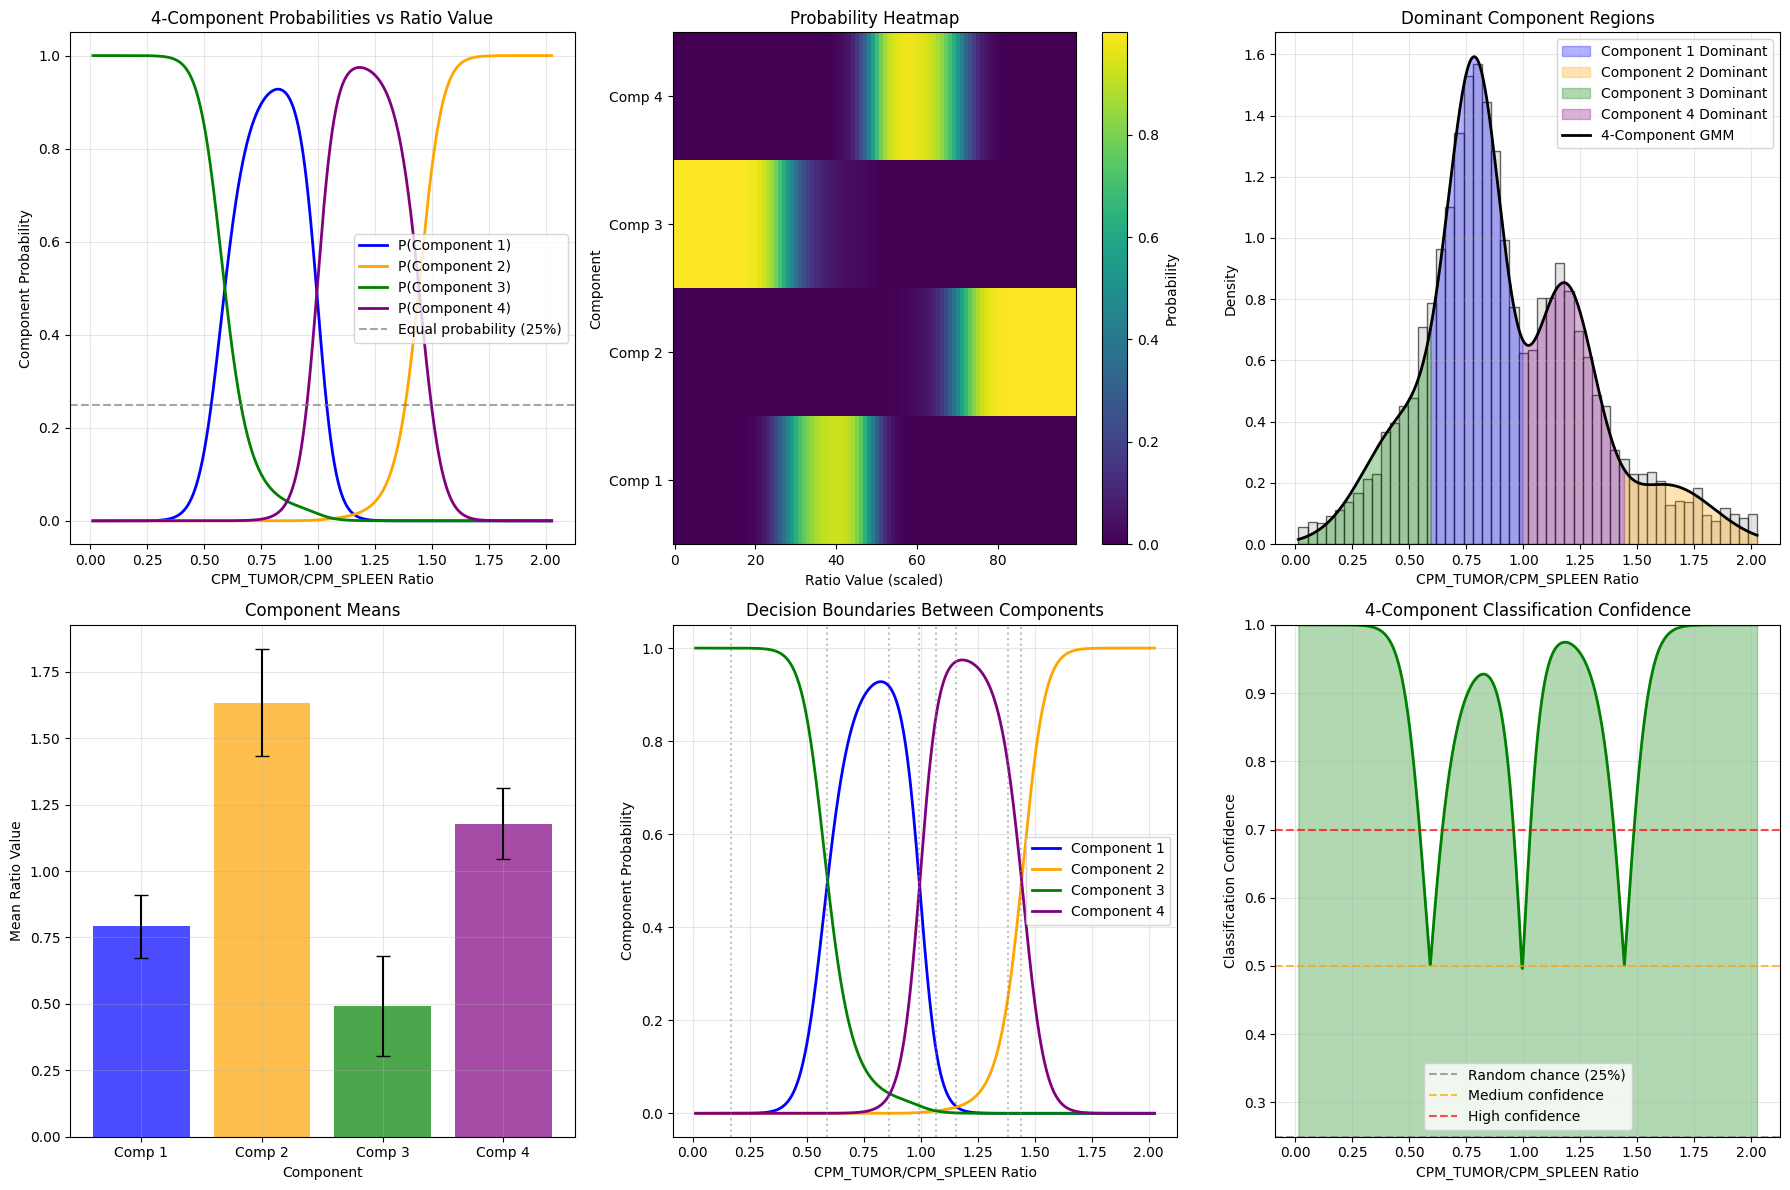

In [97]:
# Comprehensive 4-Component Probability Visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Create probability curves for 4-component model
ratio_range = np.linspace(ratio_1d.min(), ratio_1d.max(), 1000)
probs_4comp = get_4component_probabilities(ratio_range)

# Plot 1: All 4 component probabilities
for i in range(4):
    axes[0, 0].plot(ratio_range, probs_4comp[:, i], linewidth=2, color=colors[i],
                   label=f'P(Component {i+1})')
axes[0, 0].axhline(y=0.25, color='gray', linestyle='--', alpha=0.7, label='Equal probability (25%)')
axes[0, 0].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 0].set_ylabel('Component Probability')
axes[0, 0].set_title('4-Component Probabilities vs Ratio Value')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Probability heatmap
# Create a grid for heatmap
ratio_grid = np.linspace(ratio_1d.min(), ratio_1d.max(), 100)
prob_grid = get_4component_probabilities(ratio_grid)
im = axes[0, 1].imshow(prob_grid.T, aspect='auto', cmap='viridis', origin='lower')
axes[0, 1].set_xlabel('Ratio Value (scaled)')
axes[0, 1].set_ylabel('Component')
axes[0, 1].set_title('Probability Heatmap')
axes[0, 1].set_yticks(range(4))
axes[0, 1].set_yticklabels([f'Comp {i+1}' for i in range(4)])
plt.colorbar(im, ax=axes[0, 1], label='Probability')

# Plot 3: Data distribution with dominant component regions
axes[0, 2].hist(ratio_1d, bins=50, density=True, alpha=0.6, color='lightgray', edgecolor='black')

# Color regions by dominant component
dominant_component = np.argmax(probs_4comp, axis=1)
for i in range(4):
    mask = dominant_component == i
    if np.any(mask):
        axes[0, 2].fill_between(ratio_range[mask], 0, 
                               np.interp(ratio_range[mask], ratio_range, gmm4_pdf),
                               alpha=0.3, color=colors[i], label=f'Component {i+1} Dominant')

axes[0, 2].plot(ratio_range, gmm4_pdf, 'k-', linewidth=2, label='4-Component GMM')
axes[0, 2].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[0, 2].set_ylabel('Density')
axes[0, 2].set_title('Dominant Component Regions')
axes[0, 2].legend()
axes[0, 2].grid(True, alpha=0.3)

# Plot 4: Component characteristics comparison
component_stats = []
for i in range(4):
    mean = gmm_4.means_[i][0]
    std = np.sqrt(gmm_4.covariances_[i][0][0])
    weight = gmm_4.weights_[i]
    component_stats.append([mean, std, weight])

component_stats = np.array(component_stats)
x_pos = np.arange(4)

axes[1, 0].bar(x_pos, component_stats[:, 0], color=colors, alpha=0.7, label='Mean')
axes[1, 0].set_xlabel('Component')
axes[1, 0].set_ylabel('Mean Ratio Value')
axes[1, 0].set_title('Component Means')
axes[1, 0].set_xticks(x_pos)
axes[1, 0].set_xticklabels([f'Comp {i+1}' for i in range(4)])
axes[1, 0].grid(True, alpha=0.3)

# Add std as error bars
axes[1, 0].errorbar(x_pos, component_stats[:, 0], yerr=component_stats[:, 1], 
                   fmt='none', ecolor='black', capsize=5)

# Plot 5: Decision boundaries
axes[1, 1].plot(ratio_range, probs_4comp[:, 0], linewidth=2, color=colors[0], label='Component 1')
axes[1, 1].plot(ratio_range, probs_4comp[:, 1], linewidth=2, color=colors[1], label='Component 2')
axes[1, 1].plot(ratio_range, probs_4comp[:, 2], linewidth=2, color=colors[2], label='Component 3')
axes[1, 1].plot(ratio_range, probs_4comp[:, 3], linewidth=2, color=colors[3], label='Component 4')

# Find decision boundaries (where probabilities cross)
for i in range(3):
    for j in range(i+1, 4):
        # Find where component i and j have equal probability
        diff = probs_4comp[:, i] - probs_4comp[:, j]
        crossings = np.where(np.diff(np.signbit(diff)))[0]
        for crossing in crossings:
            if crossing < len(ratio_range)-1:
                axes[1, 1].axvline(x=ratio_range[crossing], color='gray', 
                                 linestyle=':', alpha=0.5)

axes[1, 1].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 1].set_ylabel('Component Probability')
axes[1, 1].set_title('Decision Boundaries Between Components')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

# Plot 6: Classification confidence
max_probs = np.max(probs_4comp, axis=1)
axes[1, 2].plot(ratio_range, max_probs, 'g-', linewidth=2)
axes[1, 2].fill_between(ratio_range, max_probs, alpha=0.3, color='green')
axes[1, 2].axhline(y=0.25, color='gray', linestyle='--', alpha=0.7, label='Random chance (25%)')
axes[1, 2].axhline(y=0.5, color='orange', linestyle='--', alpha=0.7, label='Medium confidence')
axes[1, 2].axhline(y=0.7, color='red', linestyle='--', alpha=0.7, label='High confidence')
axes[1, 2].set_xlabel('CPM_TUMOR/CPM_SPLEEN Ratio')
axes[1, 2].set_ylabel('Classification Confidence')
axes[1, 2].set_title('4-Component Classification Confidence')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)
axes[1, 2].set_ylim(0.25, 1.0)

plt.tight_layout()
plt.show()


In [98]:
# Sort components by mean for reference
component_order = np.argsort([gmm_4.means_[i][0] for i in range(4)])
sorted_means = [gmm_4.means_[i][0] for i in component_order]
sorted_weights = [gmm_4.weights_[i] for i in component_order]
sorted_stds = [np.sqrt(gmm_4.covariances_[i][0][0]) for i in component_order]


In [ ]:
# Save 4-Component Analysis Results
print("=== Saving 4-Component Analysis Results ===")

# Get 4-component probabilities for all data points
all_4comp_probabilities = get_4component_probabilities(ratio_1d)

# Create comprehensive dataframe with 4-component analysis
data_4comp = data.copy()

# Add individual component probabilities
for i in range(4):
    data_4comp[f'Component_{i+1}_Probability'] = all_4comp_probabilities[:, i]

# Add predicted component and confidence
data_4comp['Predicted_Component_4'] = np.argmax(all_4comp_probabilities, axis=1) + 1
data_4comp['Classification_Confidence_4'] = np.max(all_4comp_probabilities, axis=1)

# Add reliability assessment for 4-component model
def assess_reliability_4comp(confidence):
    if confidence >= 0.6:
        return "High"
    elif confidence >= 0.4:
        return "Medium"
    else:
        return "Low"

data_4comp['Reliability_4'] = data_4comp['Classification_Confidence_4'].apply(assess_reliability_4comp)

# Add component interpretation
def get_component_interpretation(component_num):
    mean = gmm_4.means_[component_num-1][0]
    if mean < 0.6:
        return "Very_Low_Ratio"
    elif mean < 0.9:
        return "Low_Ratio"
    elif mean < 1.1:
        return "Balanced_Ratio"
    else:
        return "High_Ratio"

data_4comp['Component_Type'] = data_4comp['Predicted_Component_4'].apply(get_component_interpretation)


# Save to CSV
output_file_4comp = '../Processed-Data/ProSeq_with_4component_analysis.csv'
data_4comp.to_csv(output_file_4comp, index=False)
print(f"\n✓ Saved 4-component analysis to: {output_file_4comp}")



=== Saving 4-Component Analysis Results ===
4-Component assignment summary:
Predicted_Component_4
1    4127
2     762
3    1359
4    2491
Name: count, dtype: int64

Component type distribution:
Component_Type
Low_Ratio         4127
High_Ratio        3253
Very_Low_Ratio    1359
Name: count, dtype: int64

Reliability distribution (4-component):
Reliability_4
High      8105
Medium     634
Name: count, dtype: int64

Confidence statistics (4-component):
Mean confidence: 0.8549
Min confidence: 0.4926
Max confidence: 1.0000

✓ Saved 4-component analysis to: ../Processed-Data/ProSeq_with_4component_analysis.csv
